# Introduction

This exercise addresses how to deal with data variables for MODFLOW 6 objects in FloPy. 
FloPy handles MODFLOW 6 model data in a diffferent manner from other MODFLOW model variants. 

FloPy stores MODFLOW 6 model data in data objects. These data objects are accesible via simulation or model packages. 
Data can be added to a package during construction or at a later stage through package attributes.

There are three (at the time of writting) types of model data objects:
 - MFDataScalar
 - MFDataArray
 - MFDataList

The current exercise will focus on Array Data (MFDataArray objects).

## Array Data

Array data contains data in arrays with a dimension of 1 or larger. In FloPy these data are stored in "MFArray" or "MFTransientArray" objects. 
 - MFArray objects house time-invariant arrays with one, two or three dimensions. 
    - One and two dimensional arrays do not include a layer dimension. These are used for data which applies to a single alyer or is the same for all layers. Examples include an array of values for the "top" of the model (only applies to layer 1) or for column/row dimensions in a DIS grid which are the same for all layers.
    - Three dimensional arrays additionaly contian a layer dimension. These usualy pertain to arrays of data applied to the entire model domain. 
 - MFTransientArrays, as the name implies, house arrays of data which can change over time. These usualy pertain to data applied to the entire model domain, such as time-varying rechage arrays in the RCHA package. 

We will go through a few examples of how to set, view and change array data.

In [1]:
# Import necessary libraries
# for the purposes of this course we are using frozen versions of flopy to avoid depenecy failures.  
import os 
import sys
sys.path.append('../dependencies/')
import flopy
import numpy as np
import matplotlib.pyplot as plt

# Build a Model
The following cell constructs the same model developed in exercise 1 with some modification. An additional stress period is added to the TDIS package so that MFTransientArrays can be demonstrated.

In [2]:
# simulation
sim_name = 'symple_ex04'
exe_name = os.path.join('..','bin', 'mf6.exe')
workspace = os.path.join('..','models','symple_ex04')

sim = flopy.mf6.MFSimulation(sim_name=sim_name,
                            exe_name=exe_name,
                            version="mf6", 
                            sim_ws=workspace)
# tdis
time_units = 'days'
perioddata = [(1.0, 1, 1.0), (1.0, 1, 1.0)] # an additional stress period has been added
nper = len(perioddata)
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)
# model
model_name = 'symp03'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name,
                            save_flows=True, print_flows=True)
# ims pacakge
ims = flopy.mf6.ModflowIms(sim,
                            pname="ims",
                            complexity="SIMPLE",
                            linear_acceleration="BICGSTAB",)
sim.register_ims_package(ims, [gwf.name])

# dis package
length_units = "METERS"
nlay = 3
Lx = 1000
Ly = 1500
delr = 100 #row length
delc = 100 #column length
ncol = int(Lx/delc)
nrow = int(Ly/delr)
top = 50
botm = [40, 35, 0]

dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

# IC package
strt = np.full((nlay, nrow, ncol), top)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=strt)

# NPF package
k = [5, 0.1, 10]
icelltype = [1, 0, 0]

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k,
                              save_flows=True, 
                              save_specific_discharge=True)

# RCH package
recharge = 50/1000/365
rcha = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=recharge)

# RIV package
riv_row = 7
stage = top - 5
rbot = botm[0]
cond = 0.1 * delr*delc/1

riv_spd = []
for col in range(ncol):
    riv_spd.append(((0, riv_row, col), stage, cond, rbot))

riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd, boundnames=True)

# OC package
# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are crecored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

## **Specifying Array Data**

Array data were used during the construction of the model in the first exercise (and in the cell above). 

Grid array data can be specified in several ways:
 - as a constant value (see for example the assignment of "top" in the DIS package)
 - as an n-dimensional list (see for example the assignment of "k" for each layer in the NPF package)
 - as a numpy array (see for example the assignment of "strt" for the IC package)

 The manner in which an array is assigned affects how it is written to the MODFLOW6 files and how it is stored by FloPy. The former has implications down-the-line if it relates to a parameter being adjusted during parameter estimation. The latter has implications on how the data can be accesed during model construction, should it be required.

 As an example we will assign array data to the k33 (vertical hydraulic conductivity) parameter in the NPF package. First, let's set the k33overk option to True, so that k33 represents the ratio of k33/k (i.e. the ratio of vertical to horizontal k). To do so, recall the lessons of the previous exercise on scaler data.

In [3]:
# set k33overk to True in the NPF package
npf.k33overk = True

## **Array data as a constant value**
Constant value for entire domain.

In [4]:
# let us start by assigning a single cnstant value of k33 to the entire model. 
npf.k33 = 1

In [5]:
# we can inspect how FloPy is storing the data 
npf.k33

{constant 1}

In [6]:
# although a single value is stored, we can still access values as an array if required
k33_arr = npf.k33.get_data()

# this array has dimensions (nlay, nrow, ncol).
# However, keep in mind the the model input files which FloPy will write (and MODFLOW will use) will have a single value. We will see this in a abit.
k33_arr.shape

(3, 15, 10)

## **Array data as a list**
Unique constant values per layer.

In [7]:
# set k22overk to True in the NPF package
npf.k22overk = True

In [8]:
# for example, if we wish to assign a diferent constant value of k22 (horizontal anisotropy) ratio to each layer
npf.k22 = [1, 0.1, 2]

# now we can see FloPy stores different values for each layer. 
# Seperate values for each layer will also be printed to the NPF input file.
npf.k22

Layer_1{constant 1}
Layer_2{constant 0.1}
Layer_3{constant 2}

In [9]:
# to update values for a specific layers 
npf.k22.set_data(3, layer=0)

npf.k22

Layer_1{constant 3}
Layer_2{constant 0.1}
Layer_3{constant 2}

## **Array data as an ndarray**
Values on a cell by cell basis.

[<AxesSubplot:title={'center':'k layer 1'}>,
 <AxesSubplot:title={'center':'k layer 2'}>,
 <AxesSubplot:title={'center':'k layer 3'}>]

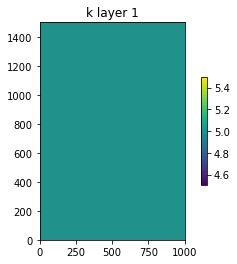

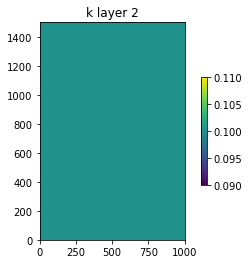

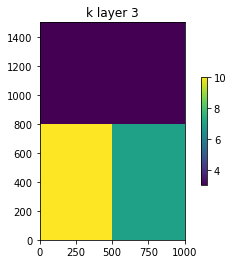

In [10]:
# Array data can also be specifed on a cell-by-cell basis using an adeqautely shaped array
# For example, for K for all model layers an array of shape (nlay, nrow, ncol). This is simple to generate using numpy
# create an array of ones with the desired shape
k = np.ones((nlay, nrow, ncol))

# now you can specify values at the layer, row or column level using slicing:
# layer 1
k[0] = 5
#layer 2
k[1] = 0.1
# layer 3
k[2] = 10
#layer 3, top half
k[2, :7] = 3
#layer 3, bottom right
k[2, 7:, 5:] = 7

# update the NPF pacakge
npf.k = k

# plot the package 
npf.k.plot(colorbar=True)

## **Mixed array types**
Working with layered arrays provides some flexibility. Consnta values can be specified for layers where hetergoeneity is not necesary, with arrays used fro layers in which they are. This reduces file sizes as memory requirements.

In [11]:
# assign a constatn value for k in layer 1 and 3, but an array in layer 2
k1 = 5
k3 = 10
k2 = np.full((nrow, ncol), 0.1)

# pass the values and array to the package in a list
npf.k = [k1, k2, k3]

npf.k

Layer_1{constant 5}
Layer_2{internal}
(array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]))
Layer_3{constant 10}

The examples above have demonstrate how to update an exising NPF package. However, the same principlies apply when constructing a package. Below we reconstruct the npf package to illustrate.

In [12]:
# rebuild the npf pacakge
# k
k1 = 5
k2 = np.full((nrow, ncol), 0.1)
k3 = 10

k = [k1, k2, k3]

#k22
k22 = [1, 0.1, 2]
#k33
k33 = 0.1

npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, 
                                    k=k,
                                    k22=k22, k33=k33,
                                    k22overk=True, k33overk=True,
                                    save_flows=True, 
                                    save_specific_discharge=True)

## **Write the model files**
Write the model files. You can compare them to those in the exercise 01 folder to see how they have changed.

In [13]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model symp03...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package rch...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 10 based on size of stress_period_data
    writing package oc...
    writing package npf...
FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis an

(True, [])

# Transient Array Data
Transient data arrays for several stress periods are specified as a dictionary of arrays, in which the dictionary key is an integer matching the (zero-based) the stress period. The dictionary value is the array data.

As for other array types, single values, lists or ndarrays can be passed. 

The following example illustrates transient array data for the RCHA package. Recall that the model has two stress periods.

In [19]:
# define recharge in stress period 1 wihth a single value 
rch_sp1 = 0.000137

# define recharge in stress period 2 with an array with recharge on only half the model domain
rch_sp2 = np.zeros((nrow, ncol)) 
rch_sp2[:7,:] = 0.000274

# construct the dictionary of stress periods and recharge arrays
rch_spd = {0: rch_sp1, 1: rch_sp2}

In [20]:
# RCHA package
rcha = flopy.mf6.ModflowGwfrcha(gwf, pname='rch', recharge=rch_spd)

In [21]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model symp03...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package riv_0...
    writing package oc...
    writing package npf...
    writing package rch...
FloPy is using the following  executable to run the model: ..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
funct

(True, [])

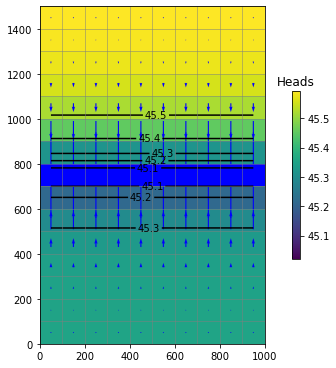

In [23]:
# plot outputs from the upper layer. The code below is the same as used in Exercise 01.

# load outputs
# the head file output can be loaded from the model object:
hds = gwf.output.head()
heads = hds.get_data(idx=-1) ### changed to read the last output

# get the specific discharge from the cell budget file
cbb = gwf.output.budget()
spdis = cbb.get_data(text="SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)


# plot
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
# first instantiate a PlotMapView
mm = flopy.plot.PlotMapView(model=gwf)

# Plot heads
# plot the array of heads 
head_array = mm.plot_array(heads)
# add contour lines with contour_array()
contours = mm.contour_array(heads, colors='black')
# add labels to contour lines
plt.clabel(contours, fmt="%2.1f")
# add a color bar
cb = plt.colorbar(head_array, shrink=0.5, )
cb.ax.set_title('Heads')

# Plot grid 
# you can plot BC cells using the plot_bc() 
mm.plot_bc('RIV', color='blue')
# and plot the model grid if desired
mm.plot_grid(lw=0.5)

# add specific discharge vectors using plot_vector()
quiver = mm.plot_vector(qx, qy, normalize=False, color='blue')